# Create hidden Markov models based on lipid tail thickness to identify ordered and disordered lipids in a liquid-liquid phase separated membrane

The notebook is an implementation of part of the methodology descirbed in [S. Park and W. Im (2019)](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b00828)

In short, a hidden Markov model is constructed to determine the underlying (or hidden) order states of lipids ($L_d$ or $L_o$) from their observed (or emitted) thicknesses. This involves the following steps:

* Calculate the **thickness of lipid tails** using **lipyphilic**

* Determine the **emission states**:
    * Emission states are values we observe (lipid thicknesses) that correlate with some hidden variable (lipid order, $L_d$ or $L_o$)
    * Decompose the distribution of lipid tail thicknesses into two Gaussians (using a Gaussian mixture model)
    * These two Guassians correspond to the thicknesses emitted by the low and high ordered hidden states, with the low order state emitting lower thicknesses
    * Lipids are then assigned emission states based on their thickness
    * All lipids with a thickness lower than the mean of the low order Gaussian are assigned an emission state of 0
    * All lipids with a thickness higher than the mean of the high order Gaussian are assigned an emission state of 8
    * Lipds with thicknesses between these means are binned into 7 bins with the bin edges evenly spaced between the low order and high order Guassian means
    
* Create an intermediate state (optional):
    * A third Gaussian is constructed through a geometric mixing of the low order and high order Gaussians. This corresponds to thicknesses emitted by the intermediate order hidden states. In this notebook we will construct a two-state model with no intermediate state.
    
* The **emission probabilites** are then calculated
    * Emission probabilities describe the probability of a hidden state emitting a particular emission state
    * The emission probabilities of each hidden state are calculated by integrating the corresponding Gaussian in the limits of each of the bin edges
    
* The emission probabilities and states are then used to **fit the parameters of a hidden Markov model** using the Baum-Welch algorithm, implemented in `hmmlearn`

* The Viterbi algorithm, also implemented in `hmmlearn`, is then used to **decode the most likely sequence of emitted states** (i.e identify whether each lipid is disordered or ordered at each frame.)

* The results are stored in a NumPy array of shape ($N_{\rm lipids}, N_{\rm frames}$). For the elements in the array, **values of -1 correspond to disordered ($L_d$) and values of 1 to ordered $L_o$**.

* Save the data to use as **input for other liyphilic analysis tools**


In [1]:
import pathlib
import joblib
from tqdm.auto import tqdm

import numpy as np
import scipy
import sklearn.mixture
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import hmmlearn.hmm
import MDAnalysis as mda

from lipyphilic.lib.z_thickness import ZThickness


We will identify $L_o$ and $L_d$ lipids in a ternary mixture of DPPC, DOPC, and Cholesterol simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3).


In [2]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

# Calculate lipid thicknesses using lpp

In [4]:
# Create a directory for storing out results, if necessary
results_directory = pathlib.Path("../results/HMM")
results_directory.mkdir(exist_ok=True)

In [5]:
# We will use the below AtomGroup for iterating over lipids in the membrane
membrane = u.select_atoms("resname DPPC DOPC CHOL")

## sn1 tail and cholesterol thickness

In [6]:
# The following atom selection will select all sn1 tail beads of the phospholipids
# as well as all cholesterol beads except for the hydroxyl group
thickness_sn1 = ZThickness(
    universe=u,
    lipid_sel="(name ??1 ??A) or (resname CHOL and not name ROH)"
)

In [7]:
# Use every frame in the analysis
thickness_sn1.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/51 [00:00<?, ?it/s]

## sn2 tail thickness only (no cholesterol)

In [8]:
# The following atom selection will select all sn2 tail beads of the phospholipids
thickness_sn2 = ZThickness(
    universe=u,
    lipid_sel="name ??2 ??B"
)

In [9]:
# Use every frame in the analysis
thickness_sn2.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/51 [00:00<?, ?it/s]

## Average the thicknesses over the two tails

In [10]:
thickness = ZThickness.average(
    thickness_sn1,
    thickness_sn2
)

In [14]:
# There is a single thickness for each lipid at each frame
# For 12000 lipids and 51 frames
thickness.z_thickness.shape

(12000, 51)

## Store results for later use

### Either as a NumPy array

In [15]:
np.save(
    results_directory.joinpath("lipid-thickness.npy"),
    thickness.z_thickness
)

### Or by serialising the object

In [16]:
joblib.dump(
    thickness,
    results_directory.joinpath("lipid-thickness.pkl")
)

['../results/HMM/lipid-thickness.pkl']

# Create a HMM based on lipid thickness with HMMLearn
Once we have created our HMMs and decoded the most likely sequence of hidden states, `lipid_order` will be a two-dimensional NumPy array with elemets equal to:
- 1 if the lipid is in the $Ld$ state
- -1 if the lipid is in the $Lo$ state


In [18]:
# This is our output array 
lipid_order = np.zeros_like(thickness.z_thickness, dtype=np.int8)

In [19]:
def get_gmm_params(gmm):
    """Get the mean, weight, and standard deviation of each Gaussian.
    
    Sort the parameters in ascending order of the mean.
    """
    
    means = gmm.means_.flatten()
    weights = gmm.weights_.flatten()
    sds = np.sqrt(gmm.covariances_).flatten()
    
    sorter = np.argsort(means)
    
    return means[sorter], weights[sorter], sds[sorter]

    

In [21]:
def add_intermediate_state(means, sds):
    """Add an intermediate Gaussian.
    """
    
    small_mean, large_mean = means
    small_sd, large_sd = sds
    
    intermediate_mean = (small_mean * large_sd + large_mean * small_sd) / (small_sd + large_sd)
    intermediate_sd = min(
        abs(small_mean - intermediate_mean),
        abs(large_mean - intermediate_mean)
    ) / 3.0
    
    new_means = np.array([small_mean, intermediate_mean, large_mean])
    new_sds = np.array([small_sd, intermediate_sd, large_sd])
    
    return new_means, new_sds
    

In [22]:
def get_emission_states(thickness, means, n_states=9):
    """Bin the raw thickness values into discrete emission states.
    """
    
    small_mean, large_mean = means[0], means[-1]
    emission_states = np.full_like(thickness, np.nan, dtype=np.int8)
    emission_state_edges = np.linspace(small_mean, large_mean, n_states-1)

    # Thicknesses less than the smaller mean have an emission state of 0
    # Thicknesses greater than the upper
    emission_states[thickness < small_mean] = 0
    emission_states[thickness > large_mean] = n_states - 1
    
    # Intermediate emission states
    for edge_index, edge in enumerate(emission_state_edges[:-1], start=1):

        state_mask = np.logical_and(
            thickness >= edge,
            thickness < emission_state_edges[edge_index]
            )

        emission_states[state_mask] = edge_index
        
    return emission_states, emission_state_edges


In [23]:
def get_emission_probs(thickness, states, edges, means, sds):
    """Calculate emission probabilities.
    
    An emission probability is the probability that a given hidden state
    emits a given emitted state.
    
    There are `n_states` emission probabilities for each hidden state,
    normalised such that the sum of emission probabilities for a given
    hidden state equals 1.
    
    The probability of an emitted state is calculated by integrating the
    Gaussian of a hidden state between the limits of emission states defined above.
    """
    
    def _calc_emission_prob(mean, sd, bin_edges):
        """Calculate the emission probability for a given Gaussian and bins.
        """
        
        x = np.linspace(
            mean - 3 * sd,
            mean + 3 * sd,
            1000
        )
        x_hist, _ = np.histogram(x, bins=bin_edges, density=True)

        return x_hist / np.sum(x_hist)
    
    # Setup edges for integration
    emission_prob_edges = np.full(edges.size + 2, fill_value=np.NaN)
    emission_prob_edges[0] = np.min(thickness)
    emission_prob_edges[1:-1] = edges
    emission_prob_edges[-1] = np.max(thickness)
    
    # Get emission probabilties for the hidden states
    emission_probs = []
    for index, mean in enumerate(means):
        
        emission_prob = _calc_emission_prob(
            mean,
            sds[index],
            emission_prob_edges
        )
        
        emission_probs.append(emission_prob)
    
    return np.asarray(emission_probs)
    

## Create a separate HMM for each species

In [24]:
n_hidden_states = 2

In [25]:
for species in tqdm(np.unique(membrane.resnames)):
    
    species_mask = membrane.residues.resnames == species
    species_thickness = thickness.z_thickness[species_mask]
    
    # Decompose the thickness distribition into two Gaussians
    mixture = sklearn.mixture.GaussianMixture(
        n_components=2,
        covariance_type="full",
        tol=1e-3
    ).fit(species_thickness.flatten().reshape(-1, 1))
          
    means, weights, sds = get_gmm_params(
        gmm=mixture
    )
    
    if n_hidden_states == 3:
        means, sds = add_intermediate_state(means, sds)
    
    # Calculate input parameters for the HMM
    emission_states, emission_state_edges = get_emission_states(
        thickness=species_thickness,
        means=means,
        n_states=9
    )
    
    emission_probs = get_emission_probs(
        species_thickness,
        states=emission_states,
        edges=emission_state_edges,
        means=means,
        sds=sds
    )
    
    # Construct the model
    n_lipids, n_frames = species_thickness.shape
    lengths = np.full(n_lipids, fill_value=n_frames)
    
    model = hmmlearn.hmm.MultinomialHMM(
        n_components=n_hidden_states,
        init_params='',
        verbose=True,
        n_iter=100  # maximum number of iterations
    )
    model.emissionprob_ = emission_probs
    
    # Train the model
    model = model.fit(
        np.concatenate(emission_states).reshape(-1,1),
        lengths=lengths
    )
    
    # Decode most likely sequence of hidden states
    _, species_order = model.decode(
        np.concatenate(emission_states).reshape(-1,1),
        lengths=lengths
    )
    species_order = species_order.reshape(emission_states.shape)
    
    # ensure Ld = -1, Ld/o = 0, Lo = 1
    if n_hidden_states == 3:
        species_order -= 1
    else:
        species_order[species_order == 0] = -1
    
    # store the results for this species
    lipid_order[species_mask] = species_order
    
    # Save the model for later use if necessary
    # e.g. the HMM for future refitting or decoding
    joblib.dump(
        model,
        results_directory.joinpath(f"{species}-thickness-HMM.pkl")
    )

# Save the ordered states of all lipids
np.save(
    results_directory.joinpath("lipid-order.npy"),
    lipid_order
)


  0%|          | 0/3 [00:00<?, ?it/s]

         1     -429333.6111             +nan
         2     -339055.2346      +90278.3765
         3     -338996.3902         +58.8444
         4     -338934.9414         +61.4487
         5     -338868.7363         +66.2051
         6     -338795.1425         +73.5939
         7     -338710.7825         +84.3600
         8     -338611.1527         +99.6297
         9     -338490.0550        +121.0977
        10     -338338.7314        +151.3236
        11     -338144.5332        +194.1983
        12     -337888.8760        +255.6572
        13     -337544.1804        +344.6956
        14     -337069.6366        +474.5438
        15     -336406.5525        +663.0841
        16     -335477.2740        +929.2785
        17     -334199.7275       +1277.5464
        18     -332539.9245       +1659.8031
        19     -330605.8717       +1934.0527
        20     -328682.1525       +1923.7193
        21     -327047.6837       +1634.4688
        22     -325743.1073       +1304.5764
        23

# Check the output

The results we are interested in are stored in the two-dimensional NumPy array `lipid_order`.

This results array is the same format as many of those in LiPyphilic: the rows correspond to individual lipids and the columns correspond to individual frames. As mentioned:

- values of 1 indicate the lipid is in the $Ld$ state
- values of -1 indicate the lipid is in the $Ld$ state


In [46]:
lipid_order

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

In [47]:
# There are 12000 lipids in the membrane 
lipid_order.shape

(12000, 51)

# Plot fraction of states over time

How does the fraction of $L_o$ or $L_d$ states evolve over time? Do we see an increase in $L_o$ lipids, which could signal the formation of an $L_o$ domain?


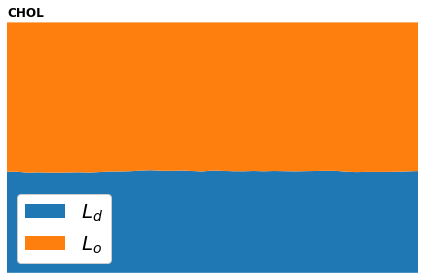

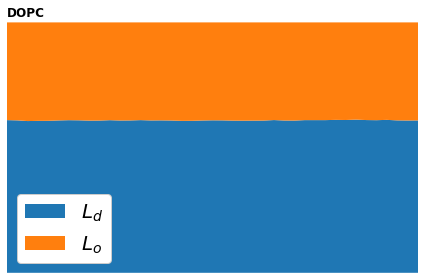

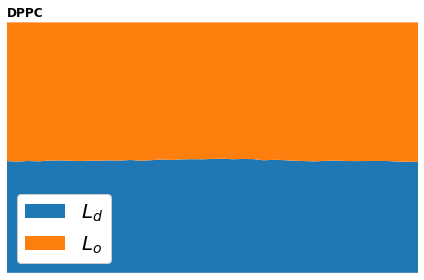

In [29]:
labels = [r"$L_d$", r"$L_o$"]
for species in np.unique(membrane.resnames):
    
    # extract Lo and Ld states for this species
    species_order = lipid_order[membrane.residues.resnames == species]
    
    # Count the number of each state (Ld or Lo) at each frame
    count_disordered = np.apply_along_axis(lambda x: np.count_nonzero(x==-1), axis=0, arr=species_order)
    count_ordered = np.apply_along_axis(lambda x: np.count_nonzero(x==1), axis=0, arr=species_order)
    
    # Combine these values into a 2d array for plotting
    order_by_frame = np.vstack([count_disordered, count_ordered])
    
    fig, ax = plt.subplots()
    plt.stackplot(
        np.arange(order_by_frame.shape[1]),
        order_by_frame/np.sum(order_by_frame, axis=0),
        labels=labels,
        baseline="zero",
        lw=0.0,
        alpha=1
    )
    plt.margins(-0.1,0)
    plt.axis("off")

    leg = plt.legend(fancybox=True, framealpha=1, loc=3, fontsize=20)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.title(species, loc="left", weight="bold")
    
    plt.tight_layout()
    plt.show()


There is very little change over time in the distribution of states. 

However, we have only used 51 frames in the analysis, with 5 ns between frames.

**To better capture transitions between states, a smaller interval between frames (such as 1 ns) should be used.**


## Plot the thickness distribution of each state

How well separated are the thickness distributions of lipids in the $L_o$ and $L_d$ states?


CHOL L_d mean thickness: 10.16 Å
CHOL L_o mean thickness: 11.70 Å


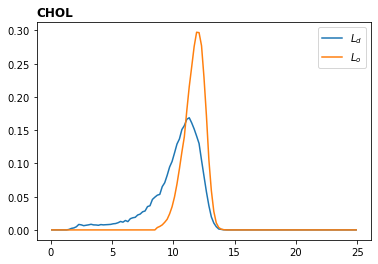

DOPC L_d mean thickness: 12.22 Å
DOPC L_o mean thickness: 14.61 Å


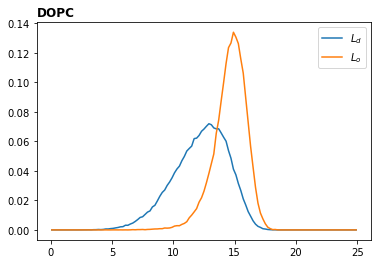

DPPC L_d mean thickness: 13.35 Å
DPPC L_o mean thickness: 15.67 Å


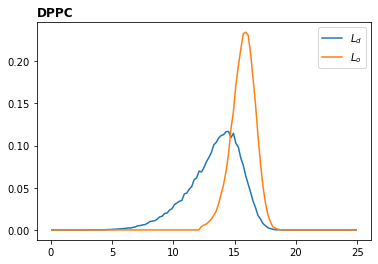

In [43]:
bin_edges = np.linspace(0, 25.0, 126)
bin_centers = bin_edges[:-1] + np.diff(bin_edges)[0] / 2
labels = [r"$L_d$", r"$L_o$"]

for species in np.unique(membrane.resnames):

    species_mask = membrane.residues.resnames == species
    species_thickness = thickness.z_thickness[species_mask]
    species_order = lipid_order[species_mask]
    
    # We want out histograms to be weighted by the relative prevalance of Lo and Ld states
    hmm_weights = np.array([
        np.sum(species_order == -1),
        np.sum(species_order == 1),
    ]) / species_order.size
    
    for index, state in enumerate([-1, 1]):
    
        hist, bins= np.histogram(species_thickness[species_order == state].flatten(), bins=bin_edges, density=True)
        plt.plot(bin_centers, hist * hmm_weights[state], label=labels[index])
        
        print(f"{species} {labels[index][1:-1]} mean thickness: {np.mean(species_thickness[species_order == state]):.2f} Å")
        
    plt.title(species, loc="left", weight="bold")
    plt.legend()
    plt.show()


**The two states are fairly well well separated.**


See also
--------

The results (i.e. the two-dimensional NumPy array `lipid_order`) are used as input in the following tutorial notebooks:

- [Local lipid environments](4-NeighbourCounts.ipynb): The local lipid environment is quantified based on the order ($L_d$ or $L_d$) of neighbouring lipids.

- [Interleaflet registration](6-Registration.ipynb): The registration between $L_o$ lipids is calculated over time.

- [Projection plots](9-ProjectionPlot.ipynb): The lateral distribution of $L_d$ and $L_o$ lipids is projected onto the membrane plane.
